In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import tensorflow as tf

In [2]:

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.datasets import make_moons, make_blobs
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.manifold import TSNE

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [4]:
def normalization (normal_df):
    
    min_max_scaler = preprocessing.MinMaxScaler()
    feature_names = list(normal_df)
    
    min_max_scaler = min_max_scaler.fit(normal_df.values)
    X_raw_minmax = min_max_scaler.transform(normal_df.values)
    normal_df = pd.DataFrame(X_raw_minmax, columns=feature_names)

    return normal_df, min_max_scaler

In [5]:
#CONSTANTS
#MNIST_M_PATH = './Datasets/MNIST_M/mnistm.h5'

BATCH_SIZE = 30
CHANNELS = 3
EPOCH = 100


source_df = pd.read_csv('/content/gdrive/MyDrive/data/cwan/BR_ori1.csv')
target_df = pd.read_csv('/content/gdrive/MyDrive/data/cwan/SILL_ori1.csv')


source_df = source_df.sort_index()
target_df = target_df.sort_index()

In [6]:
source_x = source_df.drop(columns=['Class','username'])
target_x = target_df.drop(columns=['Class','Student_id'])

In [7]:
pca = PCA(24) 
pca.fit(target_x)
target_x_t = pca.transform(target_x)

source_x, normalizer = normalization(source_x)
target_x_t = normalizer.transform(target_x_t)


target_y = tf.one_hot(target_df['Class'], depth=2)
source_y = tf.one_hot(source_df['Class'], depth=2)

source_train_x, source_test_x, source_train_y, source_test_y = train_test_split(source_x, source_df['Class'], test_size=44,shuffle=True, random_state=0)
target_train_x, target_test_x, target_train_y, target_test_y = train_test_split(target_x_t, target_df['Class'], test_size=44, shuffle=True, random_state=0)

#source_train_x, source_test_x = source_train_x.astype('float64'), source_test_x.astype('float64')

source_train_y = tf.one_hot(source_train_y, depth=2)
source_test_y = tf.one_hot(source_test_y, depth=2)
target_train_y = tf.one_hot(target_train_y, depth=2)
target_test_y = tf.one_hot(target_test_y, depth=2)


source_train_dataset = tf.data.Dataset.from_tensor_slices((source_train_x, source_train_y)).batch(BATCH_SIZE * 2)                                
target_train_dataset = tf.data.Dataset.from_tensor_slices((target_train_x, target_train_y)).batch(BATCH_SIZE * 2)

source_test_dataset = tf.data.Dataset.from_tensor_slices((source_test_x, source_test_y)).batch(BATCH_SIZE * 2) #Test Dataset over Target Domain
target_test_dataset = tf.data.Dataset.from_tensor_slices((target_test_x, target_test_y)).batch(BATCH_SIZE * 2) #Test Dataset over Target (used for training)

da_train_dataset = tf.data.Dataset.from_tensor_slices((source_train_x, source_train_y, target_train_x, target_train_y )).batch(BATCH_SIZE)
da_test_dataset = tf.data.Dataset.from_tensor_slices((source_test_x, source_test_y, target_test_x, target_test_y )).batch(BATCH_SIZE)

In [8]:
source_train_x.shape

(60, 24)

In [9]:
source_train_y.shape

TensorShape([60, 2])

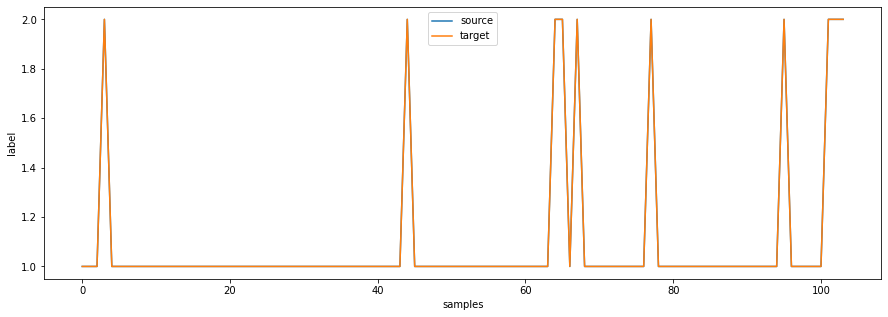

In [10]:
plt.subplots(figsize=(15,5))
plt.plot(source_df['Class'], label="source")
plt.plot(target_df['Class'], label="target")
plt.ylabel('label')
plt.xlabel('samples')
plt.legend()


In [11]:
target_train_x.shape

(60, 24)

In [12]:
#Gradient Reversal Layer
@tf.custom_gradient
def gradient_reverse(x, lamda=1.0):
    y = tf.identity(x)
    
    def grad(dy):
        return lamda * -dy, None
    
    return y, grad


class GradientReversalLayer(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
    
    def call(self, x, lamda=1.0):
        return gradient_reverse(x, lamda)



In [13]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv1D, Dropout, MaxPool1D, BatchNormalization, Dropout


class DANN(Model):
    def __init__(self):
        super().__init__()
        
        #Feature Extractor
        self.feature_extractor_layer0 = Dense(40, activation='relu')
        self.feature_extractor_layer1 = Dense(30, activation='relu')
        self.feature_extractor_layer2 = Dense(20, activation='relu')
        
        #Label Predictor
        self.label_predictor_layer0 = Dense(20, activation='relu')
        self.label_predictor_layer1 = Dense(10, activation='relu')
        self.label_predictor_layer2 = Dense(2, activation=None)
        
        #Domain Predictor
        self.domain_predictor_layer0 = GradientReversalLayer()
        self.domain_predictor_layer1 = Dense(20, activation='relu')
        self.domain_predictor_layer2 = Dense(2, activation=None)
        
    def call(self, x, train=False, source_train=True, lamda=1.0,get_features=False):
        #Feature Extractor
        x = self.feature_extractor_layer0(x)
        x = self.feature_extractor_layer1(x, training=train)
        x = self.feature_extractor_layer2(x)
        #print('DANN / feature shape:', x.shape)
        #feature = tf.reshape(x, [-1, 1 * 1 * 16])
        self.feature = x
        
        #Label Predictor
        if source_train is True:
            feature_slice = self.feature
        else:
            feature_slice = tf.slice(self.feature, [0, 0], [self.feature.shape[0] // 2, -1])
        
        lp_x = self.label_predictor_layer0(feature_slice)
        lp_x = self.label_predictor_layer1(lp_x)
        l_logits = self.label_predictor_layer2(lp_x)
        
        if get_features:
            return self.feature

        #Domain Predictor
        if source_train is True:
            return l_logits
        else:
            dp_x = self.domain_predictor_layer0(self.feature, lamda)    #GradientReversalLayer
            dp_x = self.domain_predictor_layer1(dp_x)
            d_logits = self.domain_predictor_layer2(dp_x)
            
            return l_logits, d_logits

def loss_func(input_logits, target_labels):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=input_logits, labels=target_labels))


def get_loss(l_logits, labels, d_logits=None, domain=None):
    if d_logits is None:
        return loss_func(l_logits, labels)
    else:
        return loss_func(l_logits, labels) + loss_func(d_logits, domain)



In [14]:

model = DANN()

model_optimizer = tf.optimizers.SGD()

domain_labels = np.vstack([np.tile([1., 0.], [BATCH_SIZE, 1]),
                           np.tile([0., 1.], [BATCH_SIZE, 1])])
domain_labels = domain_labels.astype('float32')


epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()
domain_accuracy = tf.keras.metrics.CategoricalAccuracy()
source_acc = []  # Source Domain Accuracy while Source-only Training
source_da_acc = []# Source Domain Accuracy while DA-training
source_test_acc = []   # Testing Dataset (Target Domain) Accuracy 
target_test_acc = []   # Target Domain (used for Training) Accuracy
target_vali_acc = []   
da_acc = []

extracted_features = []



In [16]:
@tf.function
def train_step_source(s_images, s_labels, lamda=1.0):
    images = s_images
    labels = s_labels
    
    with tf.GradientTape() as tape:
        output = model(images, train=True, source_train=True, lamda=lamda)
        #print('output', output)
        #print('labels', labels)
        model_loss = get_loss(output[1], labels)
        epoch_accuracy(output[1], labels)
        
    gradients_mdan = tape.gradient(model_loss, model.trainable_variables)
    model_optimizer.apply_gradients(zip(gradients_mdan, model.trainable_variables))


@tf.function
def train_step_da(s_images, s_labels, t_images=None, t_labels=None, lamda=1.0):
    images = tf.concat([s_images, t_images], 0)
    labels = s_labels
    
    #print('train_step_da / s_labels', s_labels)
    print('train_step_da / s_images', s_images)
    
    with tf.GradientTape() as tape:
        output = model(images, train=True, source_train=False, lamda=lamda)

        print('train_step_da / output', output)
        #print('train_step_da / labels', labels)
        
        model_loss = get_loss(output[0], labels, output[1], domain_labels)
        epoch_accuracy(output[0], labels)
        domain_accuracy(output[1], domain_labels)
        #extracted_features.append(output[2])
        #print(extracted_features)
        
    gradients_mdan = tape.gradient(model_loss, model.trainable_variables)
    model_optimizer.apply_gradients(zip(gradients_mdan, model.trainable_variables))


@tf.function
def test_step(t_images, t_labels):
    images = t_images
    labels = t_labels
    
    output = model(images, train=False, source_train=True)
    epoch_accuracy(output, labels)
    
def get_features(s_images, s_labels, t_images=None, t_labels=None):
    output = model(s_images, s_labels, t_images, t_labels, get_features=True)
    extracted_features.append(output)


def train(train_mode, epochs=EPOCH):
    
    if train_mode == 'source':
        dataset = source_train_dataset
        train_func = train_step_source
        acc_list = source_acc
    elif train_mode == 'domain-adaptation':
        dataset = da_train_dataset
        train_func = train_step_da
        acc_list = source_da_acc
    else:
        raise ValueError("Unknown training Mode")
    
    for epoch in range(epochs):
        p = float(epoch) / epochs
        lamda = 2 / (1 + np.exp(-100 * p, dtype=np.float32)) - 1
        lamda = lamda.astype('float32')

        for batch in dataset:
            #print('train_func batch', batch.shape)
            train_func(*batch, lamda=lamda)
        
        #print("Training: Epoch {} :\t Source Accuracy : {:.3%}".format(epoch, epoch_accuracy.result()), end='  |  ')
        print("Training: Epoch {} :\t ".format(epoch), end='  |  ')
        acc_list.append(epoch_accuracy.result())
        test()
        epoch_accuracy.reset_states()


def test():
    epoch_accuracy.reset_states()
    
    #Testing Dataset (Target Domain)
    for batch in source_test_dataset:
        test_step(*batch)
        
    print("Source Accuracy : {:.3%}".format(epoch_accuracy.result()), end='  |  ')
    source_test_acc.append(epoch_accuracy.result())
    epoch_accuracy.reset_states()
    
    #Target Domain (used for Training)
    for batch in target_test_dataset:
        test_step(*batch)
        
    for batch in da_test_dataset:
        get_features(*batch)
    
    print("Target Accuracy : {:.3%}".format(epoch_accuracy.result()), end='  |  ')
    target_test_acc.append(epoch_accuracy.result())
    
    print("Domain Accuracy : {:.3%}".format(domain_accuracy.result()))
    da_acc.append(domain_accuracy.result())
    epoch_accuracy.reset_states()

In [17]:

#tf.executing_eagerly()
#Training
#train('source', 5)

train_method='domain-adaptation'
train(train_method, EPOCH)




train_step_da / s_images Tensor("s_images:0", shape=(30, 24), dtype=float64)
train_step_da / output (<tf.Tensor 'dann/dense_5/BiasAdd:0' shape=(30, 2) dtype=float32>, <tf.Tensor 'dann/dense_7/BiasAdd:0' shape=(60, 2) dtype=float32>)
train_step_da / s_images Tensor("s_images:0", shape=(30, 24), dtype=float64)
train_step_da / output (<tf.Tensor 'dann/dense_5/BiasAdd:0' shape=(30, 2) dtype=float32>, <tf.Tensor 'dann/dense_7/BiasAdd:0' shape=(60, 2) dtype=float32>)
Training: Epoch 0 :	   |  Source Accuracy : 47.727%  |  Target Accuracy : 86.364%  |  Domain Accuracy : 22.500%
Training: Epoch 1 :	   |  Source Accuracy : 77.273%  |  Target Accuracy : 90.909%  |  Domain Accuracy : 27.083%
Training: Epoch 2 :	   |  Source Accuracy : 88.636%  |  Target Accuracy : 93.182%  |  Domain Accuracy : 30.278%
Training: Epoch 3 :	   |  Source Accuracy : 93.182%  |  Target Accuracy : 95.455%  |  Domain Accuracy : 32.500%
Training: Epoch 4 :	   |  Source Accuracy : 93.182%  |  Target Accuracy : 95.455%  |  

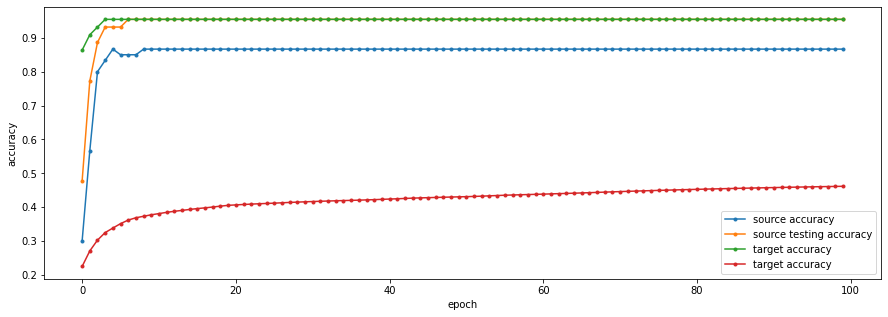

In [27]:
#Plot Results
x_axis = [i for i in range(0, EPOCH)]
plt.subplots(figsize=(15,5))
plt.plot(x_axis, source_da_acc, label="source accuracy", marker='.')
plt.plot(x_axis, source_test_acc, label="source testing accuracy", marker='.')
plt.plot(x_axis, target_test_acc, label="target accuracy", marker='.')

if train_method == 'domain-adaptation':
    plt.plot(x_axis, da_acc, label="target accuracy", marker='.')
    
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

In [19]:
extracted_features[0].numpy().shape

(30, 20)

In [20]:
feature_da_np = np.concatenate(extracted_features, axis=0)

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=1000, verbose=1)
dann_tsne_1 = tsne.fit_transform(np.concatenate(extracted_features, axis=0))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4400 samples in 0.012s...
[t-SNE] Computed neighbors for 4400 samples in 0.293s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4400
[t-SNE] Computed conditional probabilities for sample 2000 / 4400
[t-SNE] Computed conditional probabilities for sample 3000 / 4400
[t-SNE] Computed conditional probabilities for sample 4000 / 4400
[t-SNE] Computed conditional probabilities for sample 4400 / 4400
[t-SNE] Mean sigma: 0.031202
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.238365
[t-SNE] KL divergence after 1000 iterations: 0.381707


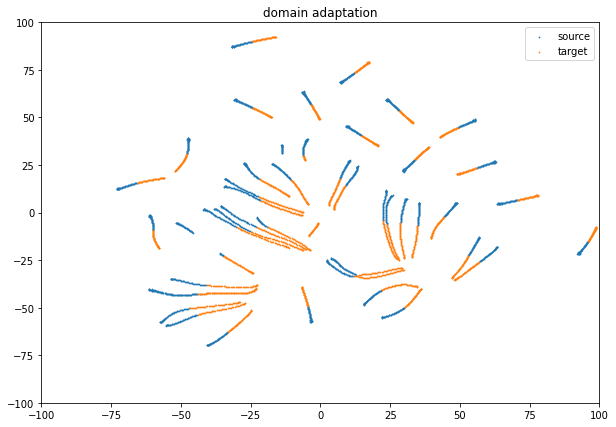

In [21]:
plt.subplots(figsize=(10,7))
source_da_tsne = dann_tsne_1[:dann_tsne_1.shape[0]//2]
target_da_tsne = dann_tsne_1[dann_tsne_1.shape[0]//2:]

plt.title('domain adaptation')
plt.scatter(source_da_tsne[:,0], source_da_tsne[:,1], s=0.5, label="source")
plt.scatter(target_da_tsne[:,0], target_da_tsne[:,1], s=0.5, label="target")
plt.xlim(-100, 100)
plt.ylim(-100, 100)
plt.legend()

In [22]:
dann_tsne_2 = tsne.fit_transform(np.concatenate((source_test_x, target_test_x), axis=0))


[t-SNE] Computing 87 nearest neighbors...
[t-SNE] Indexed 88 samples in 0.000s...
[t-SNE] Computed neighbors for 88 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 88 / 88
[t-SNE] Mean sigma: 0.595652
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.243507
[t-SNE] KL divergence after 1000 iterations: 0.334189


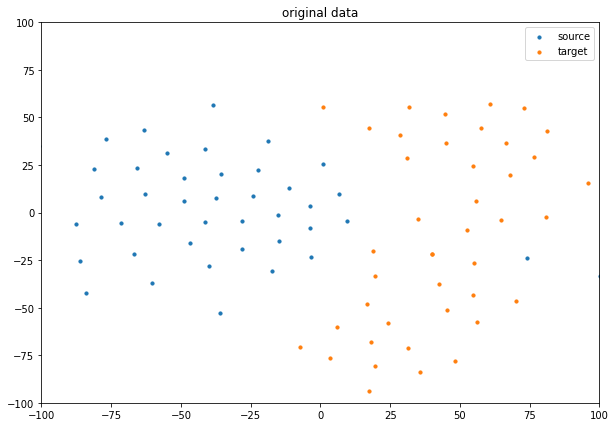

In [23]:
plt.subplots(figsize=(10,7))

plt.title('original data')

source_tsne = dann_tsne_2[:dann_tsne_2.shape[0]//2]
target_tsne = dann_tsne_2[dann_tsne_2.shape[0]//2:]

plt.scatter(source_tsne[:,0], source_tsne[:,1], s=10, label="source")
plt.scatter(target_tsne[:,0], target_tsne[:,1], s=10, label="target")
plt.xlim(-100, 100)
plt.ylim(-100, 100)
plt.legend()

In [24]:
#extracted_features[1].shape
print(target_test_x.shape)

(44, 24)


In [25]:
from sklearn.decomposition import PCA

pca_scale = PCA(n_components=2)
pca_scale = pca_scale.fit(source_x)

source_x_dr = pca_scale.transform(source_x)
x_min, x_max = source_x_dr.min(0), source_x_dr.max(0)
X_norm = (source_x_dr-x_min) / (x_max-x_min)  #Normalize
source_x_df = pd.DataFrame(X_norm, columns = ['dim1','dim2'])

target_x_dr = pca_scale.transform(target_x_t)
x_min, x_max = target_x_dr.min(0), target_x_dr.max(0)
X_norm = (target_x_dr-x_min) / (x_max-x_min)  #Normalize
target_x_df = pd.DataFrame(X_norm, columns = ['dim1','dim2'])


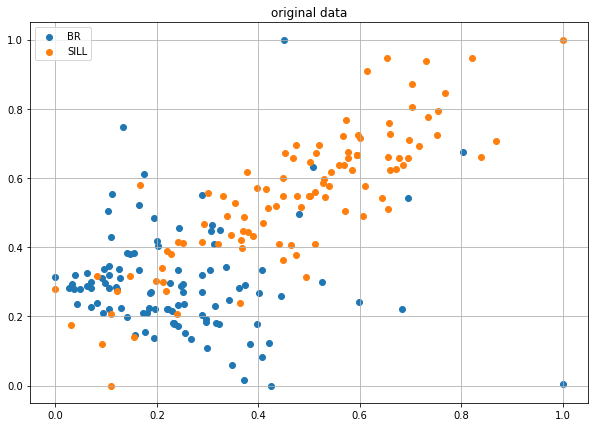

In [26]:
fig, ax = plt.subplots(figsize=(10,7))

plt.title('original data')
ax.scatter(source_x_df['dim1'], source_x_df['dim2'], alpha=1, label='BR')
ax.scatter(target_x_df['dim1'], target_x_df['dim2'], alpha=1, label='SILL')


ax.legend()
ax.grid(True)

#plt.ylim(0, 1)
#plt.xlim(0, 1)
#plt.savefig('distribution.png', dpi=300)
plt.show()